In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal

In [2]:
# ------------------------
# Snippet 0: Device Setup
# ------------------------
# Use Apple M1’s GPU via MPS if available, else CPU
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}\n")

Using device: mps



In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BayesianTransformerRegressor(nn.Module):
    def __init__(
        self,
        input_dim=2,
        d_model=100,
        nhead=1,
        dim_feedforward=100,
        num_encoder_layers=1,
        p_dropout=0.1
    ):
        super().__init__()
        # ————————————
        # 1) Embed (x,y) → d_model + nonlinearity
        # ————————————
        self.embed = nn.Sequential(
            nn.Linear(input_dim, d_model),
            nn.ReLU(),
            nn.Dropout(p_dropout),

            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(p_dropout),

            nn.Linear(d_model, d_model),
            nn.Dropout(p_dropout)

        )

        # —————————————————————
        # 2) Transformer encoder stack
        # —————————————————————
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=p_dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_encoder_layers)

        # ———————————————————————
        # 3) Deep output head (2 extra layers)
        # ———————————————————————
        self.out_mlp = nn.Sequential(

            nn.Linear(d_model, 2),

        )

    def forward(self, seq):
        """
        seq: (batch, seq_len, 2) tensor of (x, masked_y)
        returns: (mean, std) each of shape (batch, seq_len)
        """
        # 1) embed + nonlinearity
        h = self.embed(seq)                # → (B, L, d_model)

        # 2) build causal mask so j > i positions are masked out
        L = h.size(1)
        mask = torch.triu(torch.full((L, L), float('-inf'), device=h.device), diagonal=1)

        # 3) transformer with causal attention
        h = self.encoder(h, mask=mask)     # → (B, L, d_model)

        # 4) deep MLP head to [mean, log_std]
        out = self.out_mlp(h)              # → (B, L, 2)
        mean    = out[..., 0]              # → (B, L)
        log_std = out[..., 1]
        std     = torch.exp(log_std)       # ensure positivity

        return mean, std

# instantiate and move to GPU/CPU
model = BayesianTransformerRegressor(
    input_dim=2,
    d_model=64,             # you can bump this up too
    nhead=1,
    dim_feedforward=256,
    num_encoder_layers=1,
    p_dropout=0.1
).to(device)

/Users/syedabidi/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch 100/1000 — NLL: 1.1911
Mean: 0.0006 ± 0.8857
True last y: -0.2877 ± 0.8765
Training on N=1...

Epoch 200/1000 — NLL: 0.5724
Mean: -0.5482 ± 0.4749
True last y: -0.2877 ± 0.8765
Training on N=1...

Epoch 300/1000 — NLL: 0.6748
Mean: -0.4263 ± 0.3701
True last y: -0.2877 ± 0.8765
Training on N=1...

Epoch 400/1000 — NLL: -0.5430
Mean: -0.3112 ± 0.2301
True last y: -0.2877 ± 0.8765
Training on N=1...

Epoch 500/1000 — NLL: 0.2359
Mean: -0.4752 ± 0.4593
True last y: -0.2877 ± 0.8765
Training on N=1...

Epoch 600/1000 — NLL: 0.0132
Mean: -0.0572 ± 0.2943
True last y: -0.2877 ± 0.8765
Training on N=1...

Epoch 700/1000 — NLL: -0.1184
Mean: -0.1678 ± 0.2450
True last y: -0.2877 ± 0.8765
Training on N=1...

Epoch 800/1000 — NLL: -0.9125
Mean: -0.3871 ± 0.1976
True last y: -0.2877 ± 0.8765
Training on N=1...

Epoch 900/1000 — NLL: 0.4789
Mean: -0.5747 ± 0.4512
True last y: -0.2877 ± 0.8765
Training on N=1...

Epoch 1000/1000 — NLL: 0.4073
Mean: -0.2495 ± 0.5461
True last y: -0.2877 ± 0.87

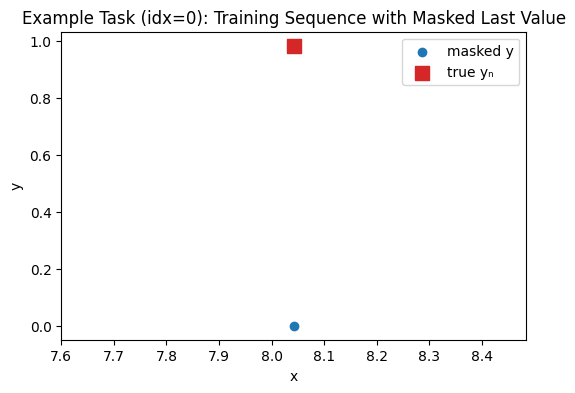

Epoch 100/1000 — NLL: -0.2356
Mean: 0.0311 ± 0.3139
True last y: 0.0738 ± 0.8764
Training on N=2...

Epoch 200/1000 — NLL: -0.4570
Mean: 0.0421 ± 0.2049
True last y: 0.0738 ± 0.8764
Training on N=2...

Epoch 300/1000 — NLL: -0.5893
Mean: 0.0004 ± 0.1394
True last y: 0.0738 ± 0.8764
Training on N=2...

Epoch 400/1000 — NLL: -0.0672
Mean: -0.0414 ± 0.1181
True last y: 0.0738 ± 0.8764
Training on N=2...

Epoch 500/1000 — NLL: -0.5920
Mean: -0.0255 ± 0.1678
True last y: 0.0738 ± 0.8764
Training on N=2...

Epoch 600/1000 — NLL: -0.9711
Mean: 0.0591 ± 0.1091
True last y: 0.0738 ± 0.8764
Training on N=2...

Epoch 700/1000 — NLL: -1.2428
Mean: 0.0939 ± 0.0952
True last y: 0.0738 ± 0.8764
Training on N=2...

Epoch 800/1000 — NLL: -1.2576
Mean: 0.0178 ± 0.1241
True last y: 0.0738 ± 0.8764
Training on N=2...

Epoch 900/1000 — NLL: -1.0140
Mean: 0.0247 ± 0.1145
True last y: 0.0738 ± 0.8764
Training on N=2...

Epoch 1000/1000 — NLL: -1.2530
Mean: 0.0026 ± 0.1019
True last y: 0.0738 ± 0.8764
Trainin

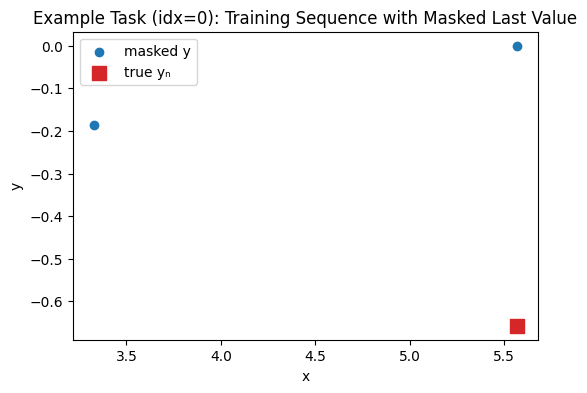

Epoch 100/1000 — NLL: 0.9951
Mean: -0.2500 ± 0.6710
True last y: -0.1201 ± 0.7593
Training on N=3...

Epoch 200/1000 — NLL: 1.0444
Mean: -0.1602 ± 0.6839
True last y: -0.1201 ± 0.7593
Training on N=3...

Epoch 300/1000 — NLL: 1.0523
Mean: -0.1596 ± 0.7135
True last y: -0.1201 ± 0.7593
Training on N=3...

Epoch 400/1000 — NLL: 1.1284
Mean: -0.1668 ± 0.6850
True last y: -0.1201 ± 0.7593
Training on N=3...

Epoch 500/1000 — NLL: 0.7325
Mean: 0.0263 ± 0.3940
True last y: -0.1201 ± 0.7593
Training on N=3...

Epoch 600/1000 — NLL: 0.9554
Mean: 0.2483 ± 0.5755
True last y: -0.1201 ± 0.7593
Training on N=3...

Epoch 700/1000 — NLL: 0.6614
Mean: -0.3399 ± 0.3351
True last y: -0.1201 ± 0.7593
Training on N=3...

Epoch 800/1000 — NLL: 0.3776
Mean: -0.1846 ± 0.2817
True last y: -0.1201 ± 0.7593
Training on N=3...

Epoch 900/1000 — NLL: -0.2480
Mean: -0.1128 ± 0.2750
True last y: -0.1201 ± 0.7593
Training on N=3...

Epoch 1000/1000 — NLL: -0.4237
Mean: -0.1832 ± 0.2006
True last y: -0.1201 ± 0.7593

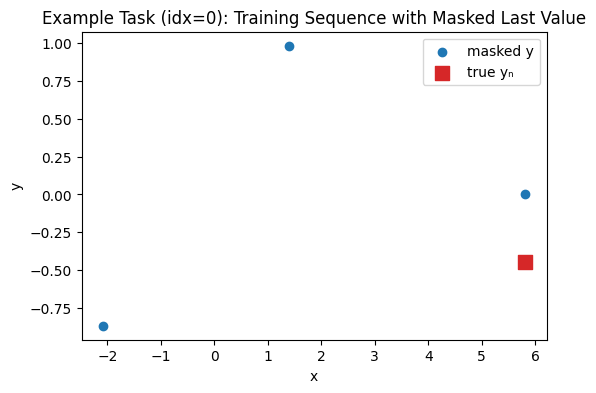

Epoch 100/1000 — NLL: -0.3741
Mean: -0.0601 ± 0.2358
True last y: -0.0082 ± 0.6166
Training on N=4...

Epoch 200/1000 — NLL: -0.1214
Mean: 0.0000 ± 0.2458
True last y: -0.0082 ± 0.6166
Training on N=4...

Epoch 300/1000 — NLL: -0.2959
Mean: -0.0186 ± 0.1999
True last y: -0.0082 ± 0.6166
Training on N=4...

Epoch 400/1000 — NLL: -0.6885
Mean: -0.0095 ± 0.2234
True last y: -0.0082 ± 0.6166
Training on N=4...

Epoch 500/1000 — NLL: -0.5139
Mean: -0.0010 ± 0.2392
True last y: -0.0082 ± 0.6166
Training on N=4...

Epoch 600/1000 — NLL: -0.0858
Mean: 0.1192 ± 0.3588
True last y: -0.0082 ± 0.6166
Training on N=4...

Epoch 700/1000 — NLL: -0.7938
Mean: -0.0209 ± 0.1875
True last y: -0.0082 ± 0.6166
Training on N=4...

Epoch 800/1000 — NLL: -0.6277
Mean: -0.0311 ± 0.1841
True last y: -0.0082 ± 0.6166
Training on N=4...

Epoch 900/1000 — NLL: -0.7306
Mean: -0.0442 ± 0.1905
True last y: -0.0082 ± 0.6166
Training on N=4...

Epoch 1000/1000 — NLL: -0.4573
Mean: -0.0181 ± 0.2013
True last y: -0.0082 

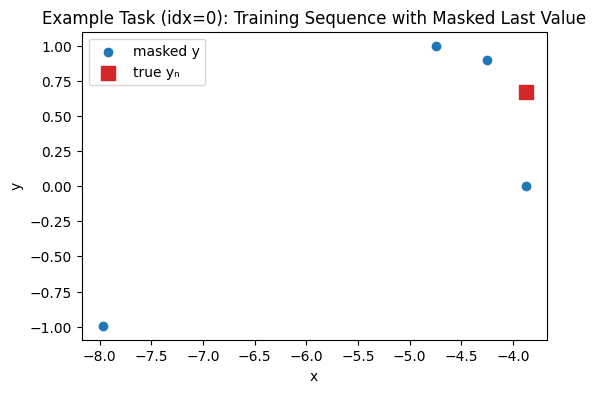

Epoch 100/1000 — NLL: -0.1286
Mean: -0.0047 ± 0.3467
True last y: -0.0118 ± 0.8979
Training on N=5...

Epoch 200/1000 — NLL: 0.0990
Mean: -0.0745 ± 0.3975
True last y: -0.0118 ± 0.8979
Training on N=5...

Epoch 300/1000 — NLL: 0.0541
Mean: -0.0087 ± 0.3255
True last y: -0.0118 ± 0.8979
Training on N=5...

Epoch 400/1000 — NLL: 0.1590
Mean: -0.1624 ± 0.4175
True last y: -0.0118 ± 0.8979
Training on N=5...

Epoch 500/1000 — NLL: -0.0616
Mean: -0.0640 ± 0.3391
True last y: -0.0118 ± 0.8979
Training on N=5...

Epoch 600/1000 — NLL: 0.2774
Mean: -0.0167 ± 0.3436
True last y: -0.0118 ± 0.8979
Training on N=5...

Epoch 700/1000 — NLL: -0.0350
Mean: -0.0394 ± 0.3222
True last y: -0.0118 ± 0.8979
Training on N=5...

Epoch 800/1000 — NLL: -0.2896
Mean: -0.0117 ± 0.3496
True last y: -0.0118 ± 0.8979
Training on N=5...

Epoch 900/1000 — NLL: 0.8888
Mean: 0.4564 ± 0.8687
True last y: -0.0118 ± 0.8979
Training on N=5...

Epoch 1000/1000 — NLL: 0.7721
Mean: 0.2657 ± 0.5389
True last y: -0.0118 ± 0.89

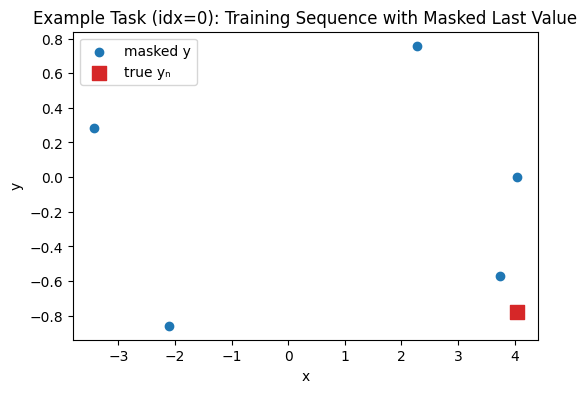

In [4]:
# 1: Generate M training tasks, each length N, mask last y

#Give N_range
N_range = (1, 5)
# Generate M tasks of length N
for N in range(N_range[0], N_range[1]+1):


    M = 5
    tasks_x = np.random.uniform(-10, 10, size=(M, N))
    tasks_x.sort(axis=1)
    tasks_y = np.sin(tasks_x)
    tasks_y_masked = tasks_y.copy()
    tasks_y_masked[:, -1] = 0.0
    data = np.stack([tasks_x, tasks_y_masked], axis=2)  # (M, N, 2)

    # Move to torch tensors
    data_t    = torch.tensor(data, dtype=torch.float32).to(device)      # (M, N, 2)
    true_last = torch.tensor(tasks_y[:, -1], dtype=torch.float32).to(device)  # (M,)



    # 4️⃣ Training loop with negative log-likelihood
    # ---------------------------------------
    # Snippet 3: Training Loop with MC-Dropout
    # ---------------------------------------
    # Move data to device

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    epochs    = 1000

    for ep in range(1, epochs+1):
        model.train()
        optimizer.zero_grad()

        mean_all, std_all = model(data_t)       # (M, N), (M, N)
        mean_last = mean_all[:, -1]             # (M,)
        std_last  = std_all[:, -1]              # (M,)

        dist = Normal(mean_last, std_last)
        log_p = dist.log_prob(true_last)        # (M,)
        loss  = -log_p.mean()                   # negative log-likelihood

        loss.backward()
        optimizer.step()

        if ep % 100 == 0:
            print(f"Epoch {ep}/{epochs} — NLL: {loss.item():.4f}")
            print(f"Mean: {mean_last.mean():.4f} ± {std_last.mean():.4f}")
            print(f"True last y: {true_last.mean():.4f} ± {true_last.std():.4f}")
            #Print which N_range value is being trained
            print(f"Training on N={N}...\n")

    print('Training Complete')

    # 1e) Visualize task #0 with scatter
    plt.figure(figsize=(6,4))
    # Plot all masked training points as circles
    plt.scatter(
        data[0, :, 0],        # x-coordinates
        data[0, :, 1],        # masked y-values
        marker='o',
        color='tab:blue',
        label='masked y'
    )
    # Highlight the true last yₙ as a larger square
    plt.scatter(
        tasks_x[0, -1],       # xₙ
        tasks_y[0, -1],       # true yₙ
        marker='s',
        s=100,
        color='tab:red',
        label='true yₙ'
    )
    plt.title("Example Task (idx=0): Training Sequence with Masked Last Value")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()





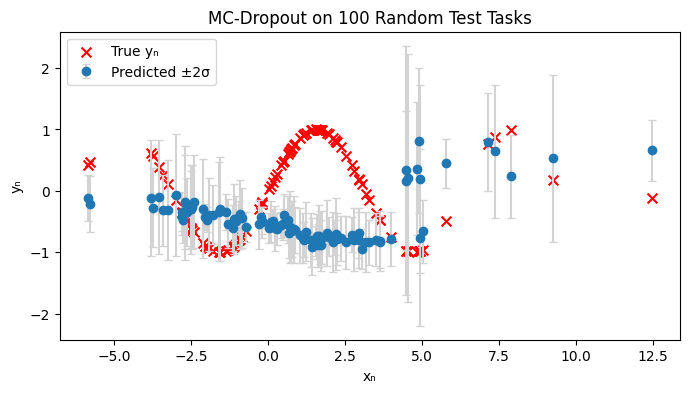

In [6]:
# 5️⃣ MC-Dropout Inference on test_num random test tasks
test_num, T = 100, 10

# Create new random tasks
tx = np.random.normal(-4, 4, size=(test_num, N))
tx.sort(axis=1)
ty = np.sin(tx)
ty_mask = ty.copy()
ty_mask[:, -1] = 0.0
data_rand   = np.stack([tx, ty_mask], axis=2)
data_rand_t = torch.tensor(data_rand, dtype=torch.float32).to(device)

model.train()  # keep dropout active
all_samps = []

for _ in range(T):
    with torch.no_grad():
        m_r, s_r = model(data_rand_t)
        # sample y_n ~ Normal(mean, std)
        samp = m_r[:, -1] + s_r[:, -1] * torch.randn(test_num, device=device)
        all_samps.append(samp.cpu().numpy())

all_samps = np.stack(all_samps, axis=0)      # (T, test_num)
mean_pred = all_samps.mean(axis=0)           # (test_num,)
std_pred  = all_samps.std(axis=0)

# Plot predictions ±2σ vs. true y_n
plt.figure(figsize=(8,4))
plt.errorbar(
    tx[:, -1], mean_pred,
    yerr=2*std_pred,
    fmt='o', ecolor='lightgray', capsize=3,
    label='Predicted ±2σ'
)
plt.scatter(
    tx[:, -1], ty[:, -1],
    color='red', marker='x', s=50,
    label='True yₙ'
)
plt.title("MC-Dropout on 100 Random Test Tasks")
plt.xlabel("xₙ")
plt.ylabel("yₙ")
plt.legend()
plt.show()
